In [4]:
import pandas as pd
import time
import numpy as np
import os
from collections import defaultdict
from sklearn.decomposition import PCA
from heavy_tail_observations import BothSideWeibullNoise, BothSideParetoNoise, BothSideFrechetNoise
from heavy_tail_lin_bandit import MENU, TOFU, SupHvyLinBandit

from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [5]:
data = pd.read_csv("Induced Musical Emotion.csv")
data

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,liked,disliked,age,gender,mother tongue
0,1,classical,0,1,0,0,0,0,1,1,0,3,1,0,21,1,English
1,1,classical,0,0,0,1,0,0,0,0,0,3,0,1,41,1,Dutch
2,1,classical,0,0,0,1,0,0,0,0,1,3,0,0,24,1,English
3,1,classical,0,0,0,0,1,0,0,0,0,3,0,0,32,0,Spanish
4,1,classical,0,0,0,1,1,0,0,0,0,4,0,1,21,0,English
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8402,400,pop,1,1,0,0,0,0,1,0,0,3,0,0,26,1,Russian
8403,400,pop,0,0,0,1,0,0,1,0,1,3,0,1,29,0,Russian
8404,400,pop,0,0,0,0,0,0,0,1,0,4,0,1,34,1,Polish
8405,400,pop,1,0,0,0,0,0,1,1,0,5,0,0,39,1,French


In [9]:
col = [' amazement', ' solemnity', ' tenderness', ' nostalgia', ' calmness', ' power', ' joyful_activation', ' tension', ' sadness', ' mood', ' liked', ' disliked']
corr = data[col].corr(method = 'pearson')
corr

,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,liked,disliked
amazement,1.000000,-0.034695,0.002308,-0.099185,-0.072947,0.046472,0.155424,-0.114553,-0.146969,0.048178,0.108304,-0.131652
solemnity,-0.034695,1.000000,-0.072575,-0.059082,-0.012520,0.012750,-0.098162,-0.040608,-0.034689,0.021121,0.084550,-0.114655
tenderness,0.002308,-0.072575,1.000000,0.087216,0.140270,-0.156100,-0.091257,-0.195904,-0.023642,0.012068,0.121795,-0.119279
nostalgia,-0.099185,-0.059082,0.087216,1.000000,0.057075,-0.155181,-0.173886,-0.190797,0.118118,-0.019525,0.017898,-0.081364
calmness,-0.072947,-0.012520,0.140270,0.057075,1.000000,-0.212538,-0.193518,-0.281527,-0.069646,-0.003863,0.104564,-0.126638
power,0.046472,0.012750,-0.156100,-0.155181,-0.212538,1.000000,0.128937,0.038252,-0.121927,0.036659,0.073678,-0.063650
joyful_activation,0.155424,-0.098162,-0.091257,-0.173886,-0.193518,0.128937,1.000000,-0.115181,-0.228275,0.016420,0.131553,-0.138436
tension,-0.114553,-0.040608,-0.195904,-0.190797,-0.281527,0.038252,-0.115181,1.000000,0.010221,-0.018809,-0.211250,0.269107
sadness,-0.146969,-0.034689,-0.023642,0.118118,-0.069646,-0.121927,-0.228275,0.010221,1.000000,-0.052243,-0.093412,0.085616
mood,0.048178,0.021121,0.012068,-0.019525,-0.003863,0.036659,0.016420,-0.018809,-0.052243,1.000000,0.054016,-0.028261


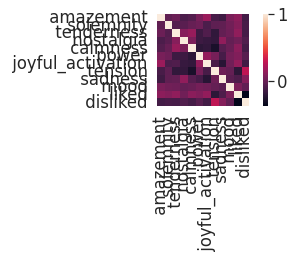

In [10]:
corr.values
col_names = col
sns.set(font_scale=1.5)

hm = sns.heatmap(corr.values, 
            cbar=True, 
            square=True, 
            fmt='.2f',
            annot_kws={'size': 15}, 
            yticklabels=col_names, 
            xticklabels=col_names) 

plt.tight_layout()
plt.show()

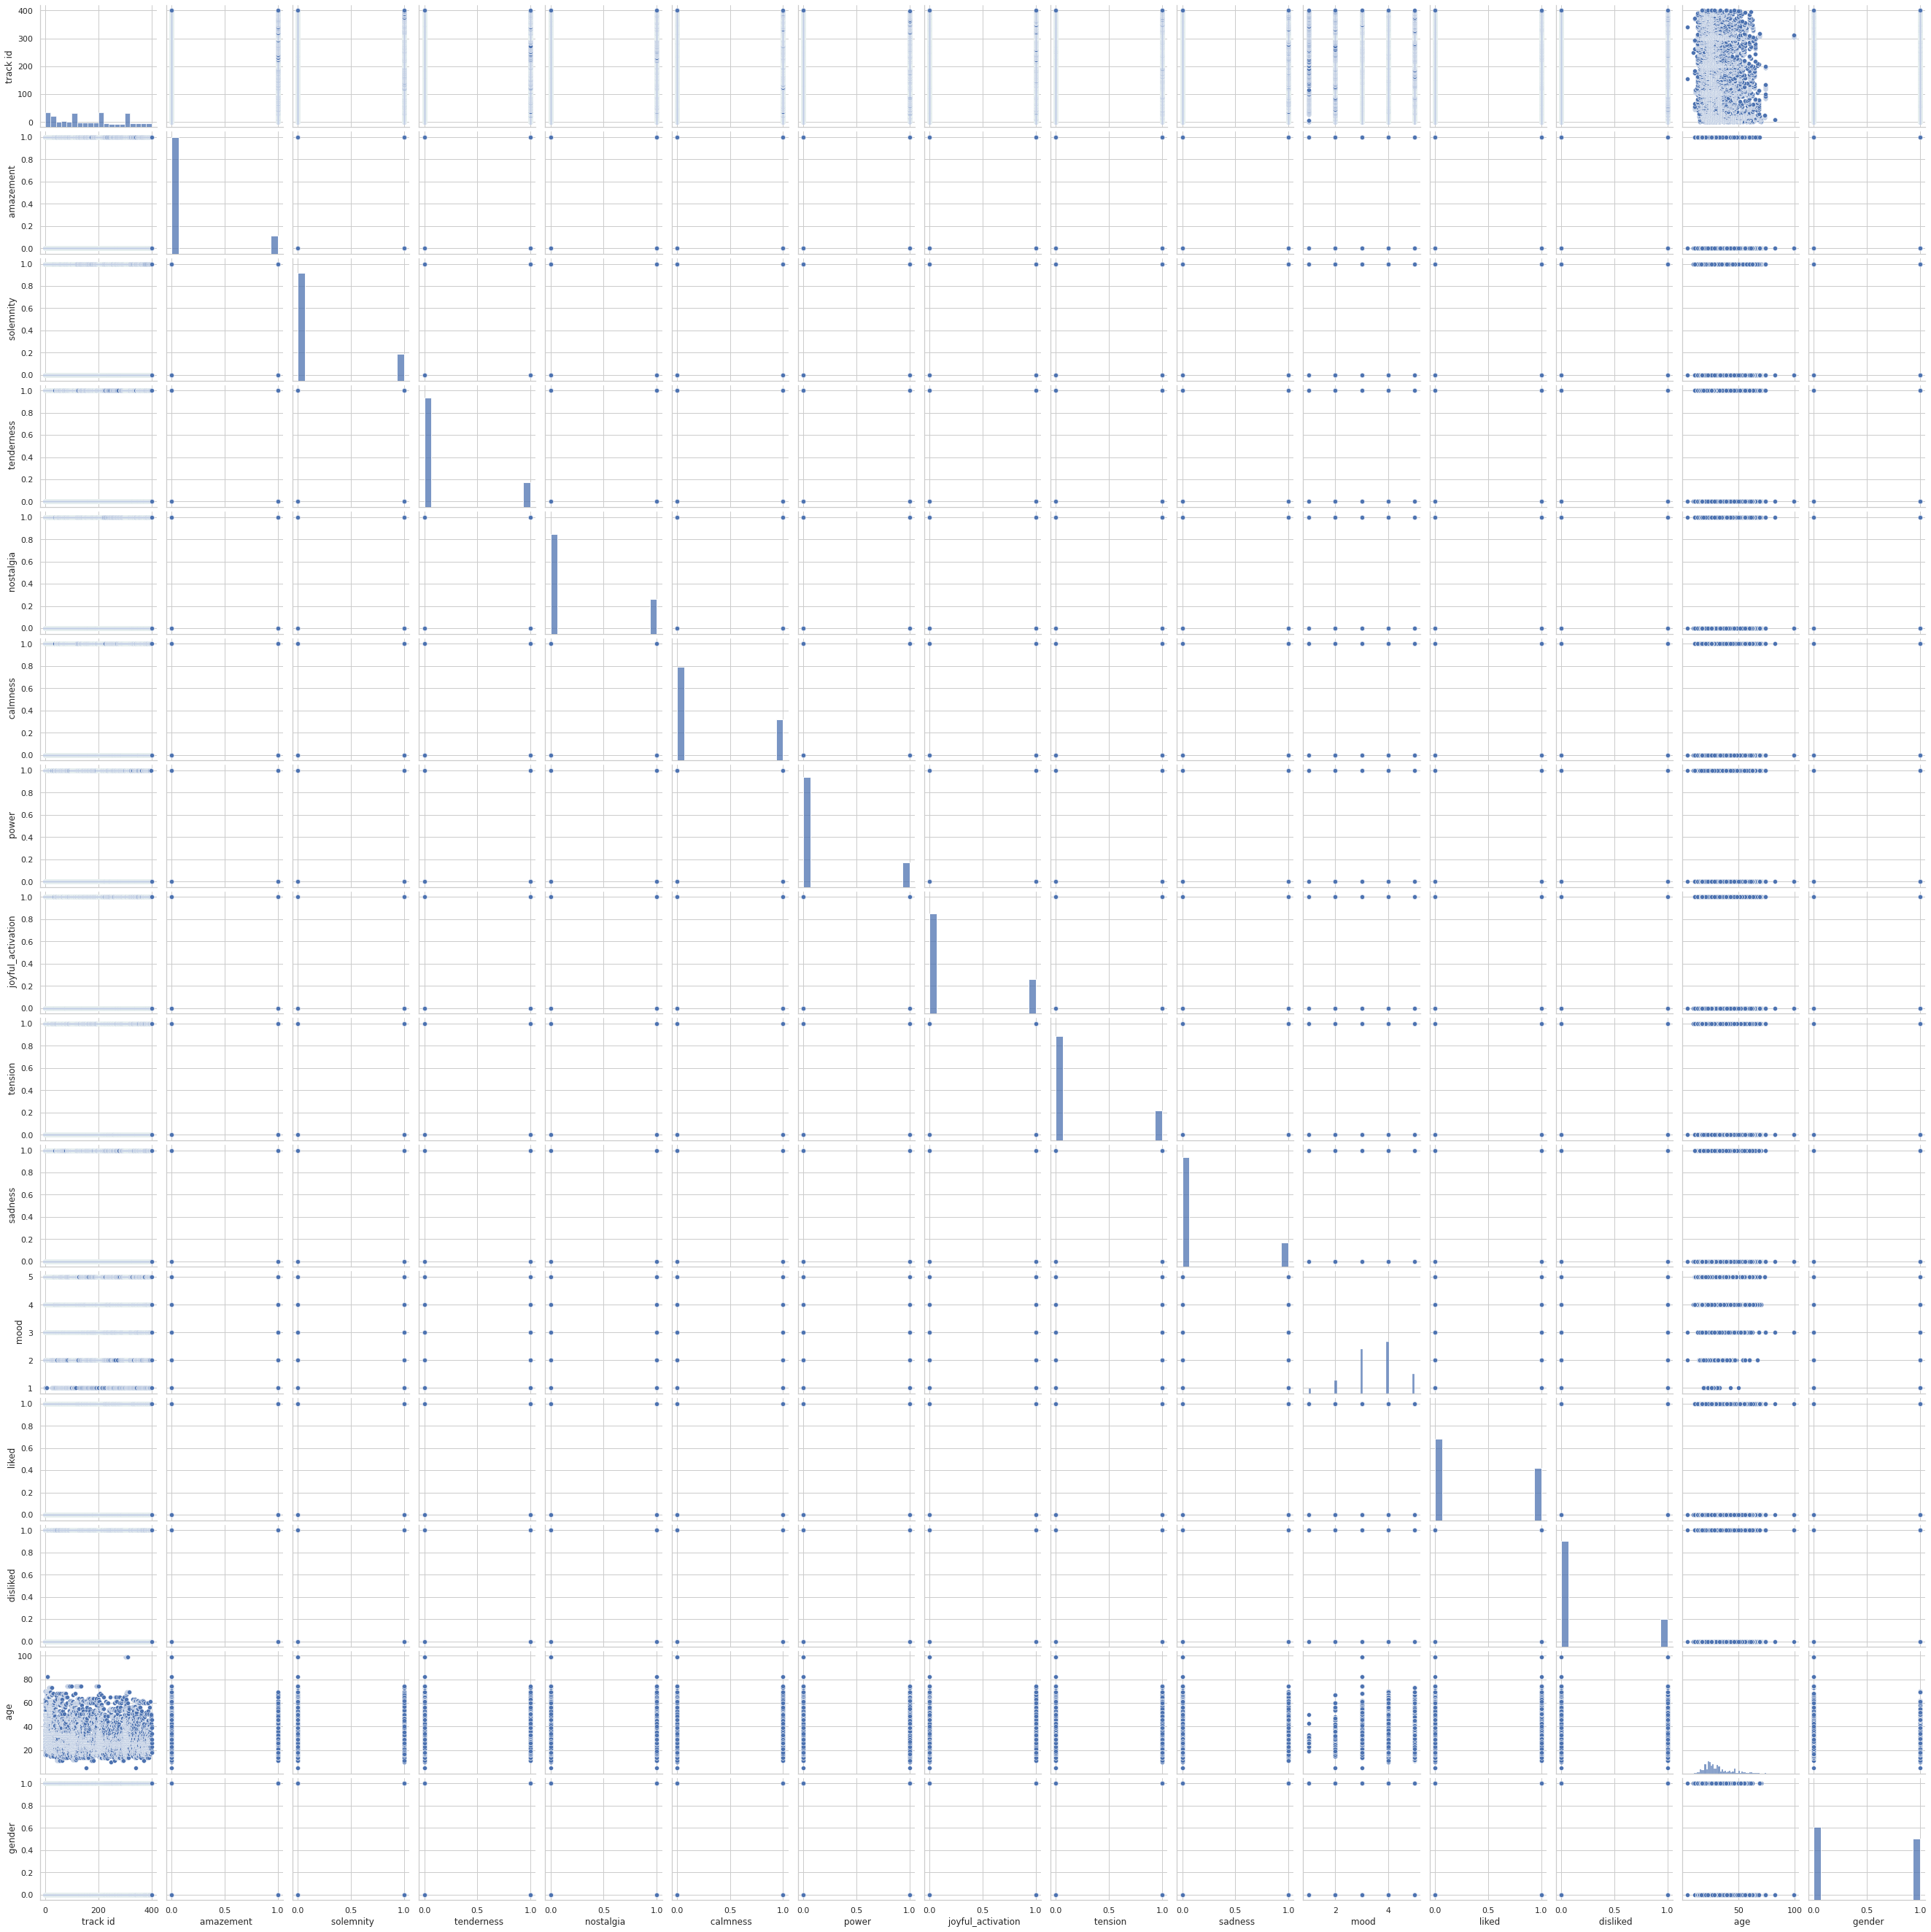

In [11]:
sns.set(style='whitegrid')
sns.pairplot(data)
plt.show()

In [11]:
print(len(data[data[' mood']==1]))
print(len(data[data[' mood']==2]))
print(len(data[data[' mood']==3]))
print(len(data[data[' mood']==4]))
print(len(data[data[' mood']==5]))

343
833
2776
3239
1216


In [5]:
data[data[' age'] == 25]

,track id,genre,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness,mood,liked,disliked,age,gender,mother tongue
32,1,classical,0,0,0,0,0,0,0,0,1,4,0,1,25,1,English
74,2,classical,0,0,0,1,0,0,0,0,1,4,1,0,25,1,English
81,2,classical,0,0,1,0,0,0,0,0,0,4,1,0,25,0,Russian
83,2,classical,0,0,0,0,1,0,0,0,0,5,0,0,25,1,Russian
112,3,classical,0,1,0,1,0,0,0,0,0,4,0,0,25,0,French
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8281,390,pop,1,0,0,1,0,0,0,0,0,3,0,1,25,1,Russian
8291,391,pop,1,0,0,0,0,0,1,0,0,4,0,0,25,1,Russian
8337,395,pop,1,0,0,0,0,0,1,0,0,4,1,0,25,1,English
8352,396,pop,0,0,0,0,0,0,0,1,0,4,0,1,25,1,English


In [61]:
data = data[:8405]
df = data.drop(['track id', ' genre', ' mood', ' liked', ' disliked', ' age', ' gender', ' mother tongue'], axis=1)
df

,amazement,solemnity,tenderness,nostalgia,calmness,power,joyful_activation,tension,sadness
0,0,1,0,0,0,0,1,1,0
1,0,0,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0,0,1
3,0,0,0,0,1,0,0,0,0
4,0,0,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...
8400,0,0,0,0,0,0,0,0,1
8401,0,0,0,0,0,0,0,1,0
8402,1,1,0,0,0,0,1,0,0
8403,0,0,0,1,0,0,1,0,1


In [42]:
np.mean(data[' liked'])

0.3915526472337894

In [43]:
np.var(data[' liked'])

0.2382391716780011

In [6]:
data[data[' disliked'] == 1][' liked']=-1

/tmp/ipykernel_7063/1333729716.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[data[' disliked'] == 1][' liked']=-1


In [12]:
y = data[' liked'].to_numpy()
X = df.to_numpy()
dim = X.shape[1]
total_samples = len(y)

T = 1681
K = int(total_samples/T)

p = 1.5
S = 1.

D = np.reshape(X, (T,K,dim))
R = np.reshape(y, (T,K))

NameError: name 'df' is not defined

In [63]:
get_mean = lambda x, y: R[y]
get_observation = lambda x, y, z: R[y][z]

In [64]:
# error_list, theta_star = MENU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, c=1.)
# error_list, theta_star = TOFU(D, get_mean, get_observation, S=S, lamb=1., delta=0.01, p=p, b=1.)
error_list, pro_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="proof", S=S, lamb=1., delta=0.001, nu = 1e-4, p=p)
# error_list, btc_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="btc", S=S, lamb=1., delta=0.001, nu = 1., p=p)
# error_list, bmm_estimator = SupHvyLinBandit(D, get_mean, get_observation, method="bmm", S=S, lamb=1., delta=0.001, nu = 1., p=p)

/home/rai/다운로드/recommendation/heavy_tail_lin_bandit.py:148: RuntimeWarning: invalid value encountered in true_divide
  c = h*Y / thrs


array([0.        , 0.5       , 0.33333333, ..., 0.49374628, 0.49404762,
       0.49375372])

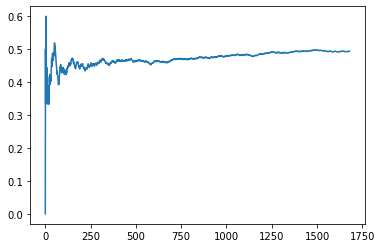

In [66]:
plt.plot(error_list)
error_list